### Analysis of Buttons Bandit

### Imports and Helper Functions

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_parent_dir_path, set_plot_style

modify_sys_path()
set_plot_style()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from csaps import csaps

### Plotting single bandit run

##### Parameters (EDIT cell below)

In [3]:
exploration_rate = 5

uncertainty_type = 'ev' # 'ev' for epistemic variance, 'aleatoric' for aleatoric uncertainty
uncertainty_name = 'Epistemic' # 'Epistemic' for epistemic variance, 'Aleatoric' for aleatoric uncertainty

results_directory = f'results/bandits/buttons/exploration_mid_0.7_{uncertainty_type}_{exploration_rate}/'

seed = 0

run_name = f"exp_{exploration_rate}_{uncertainty_type}_seed_{seed}.csv" # change this to the name of your run


In [4]:
D_data = None

for filename in os.listdir(get_parent_dir_path(results_directory)):
    if run_name in filename:
        D_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
        
        # Compute cumulative label

        D_data['cum_reward'] = D_data['label'].cumsum()
        D_data['cum_regret'] = D_data['regret'].cumsum()

In [5]:
D_data['averaged_regret'] = 0.2 * (D_data['action'] != D_data['optimal_action']).astype(int)
D_data['cum_averaged_regret'] = D_data['averaged_regret'].cumsum()

##### Cumulative Reward over Trials

Text(0.5, 1.0, 'Cumulative Reward over Trials')

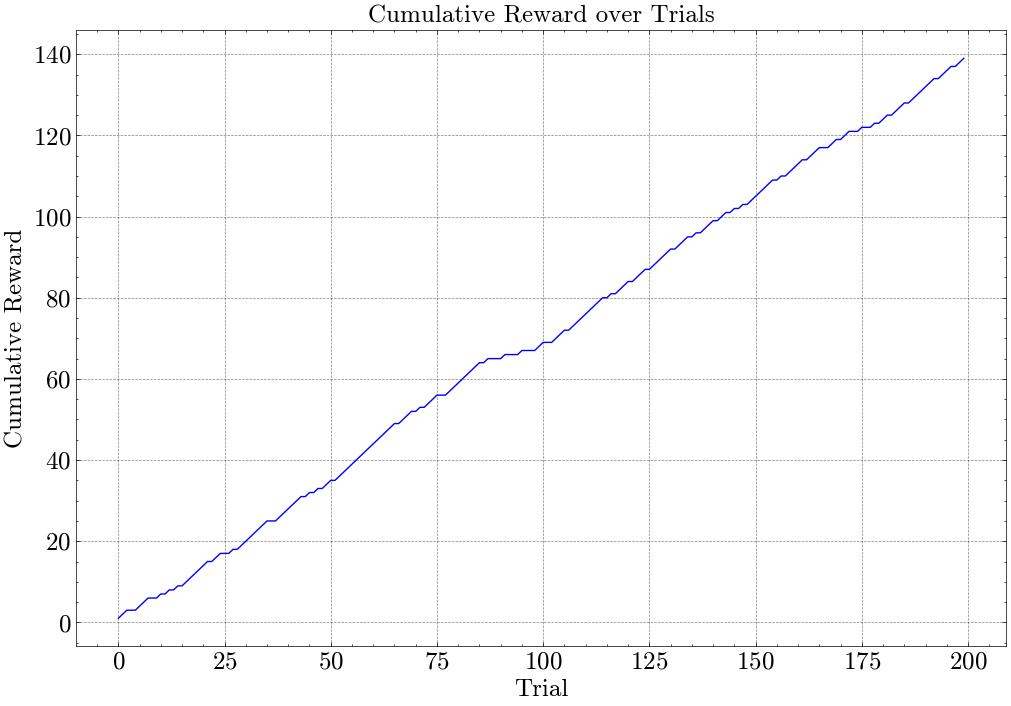

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(D_data['trial'], D_data['cum_reward'], label='Cumulative Reward', color='blue')
plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Trials')

##### Cumulative Regret Over Trials

Text(0.5, 1.0, 'Cumulative Regret over Trials')

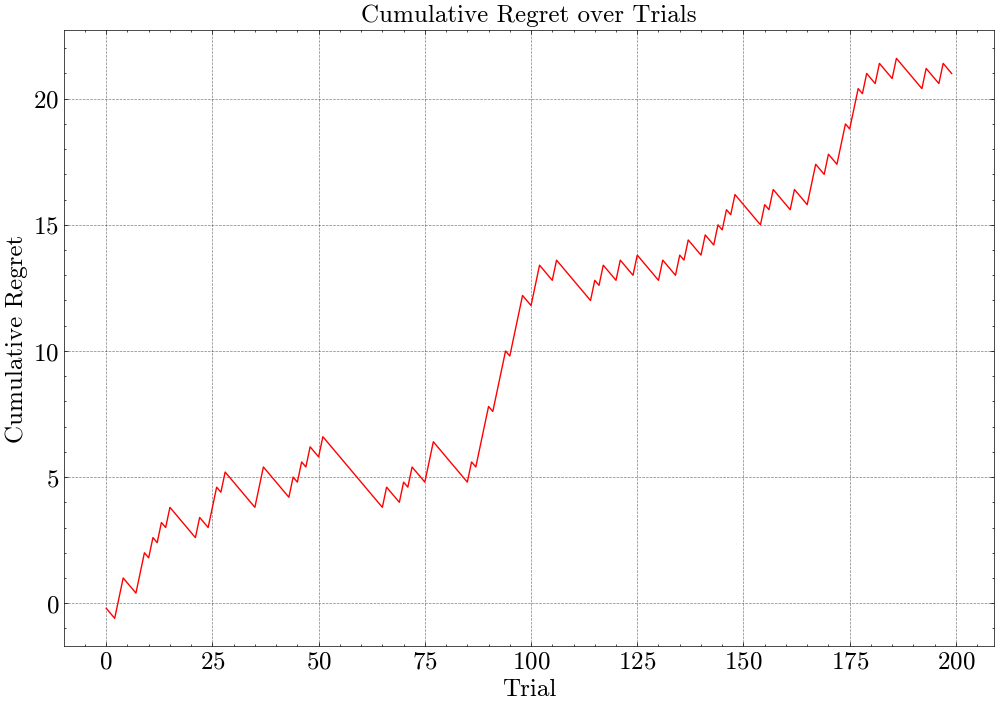

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(D_data['trial'], D_data['cum_regret'], label='Cumulative Regret', color='red')
plt.xlabel('Trial')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Trials')

##### Cumulative Averaged Regret over Trials

Text(0.5, 1.0, 'Cumulative Averaged Regret over Trials')

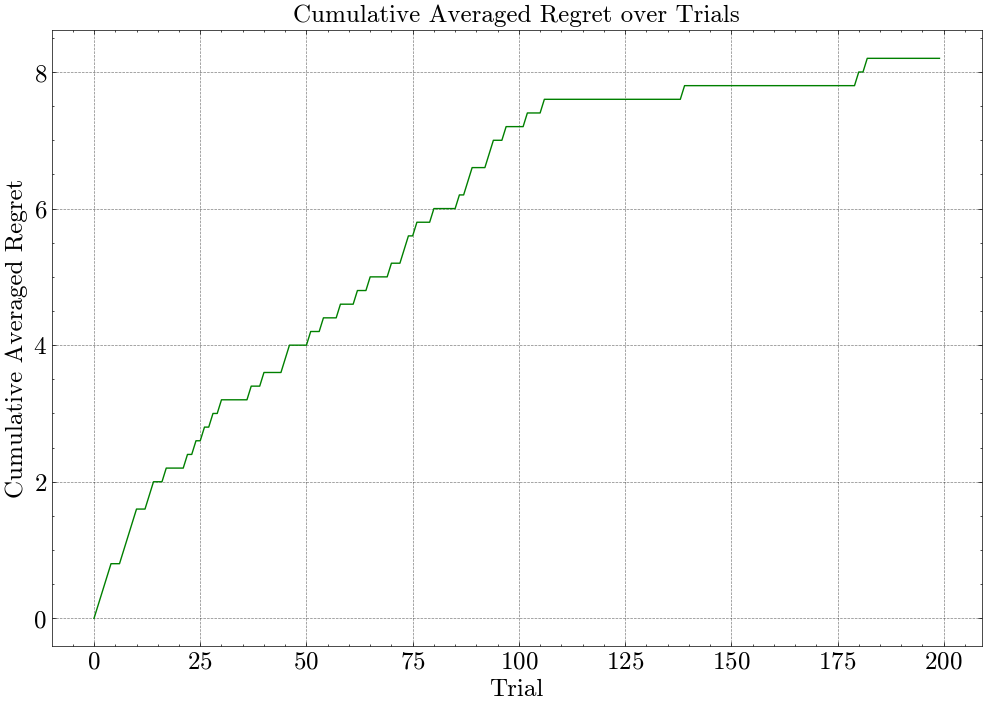

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(D_data['trial'], D_data['cum_averaged_regret'], label='Cumulative Averaged Regret', color='green')
plt.xlabel('Trial')
plt.ylabel('Cumulative Averaged Regret')
plt.title('Cumulative Averaged Regret over Trials')

##### Cumulative Action Counts over Trials

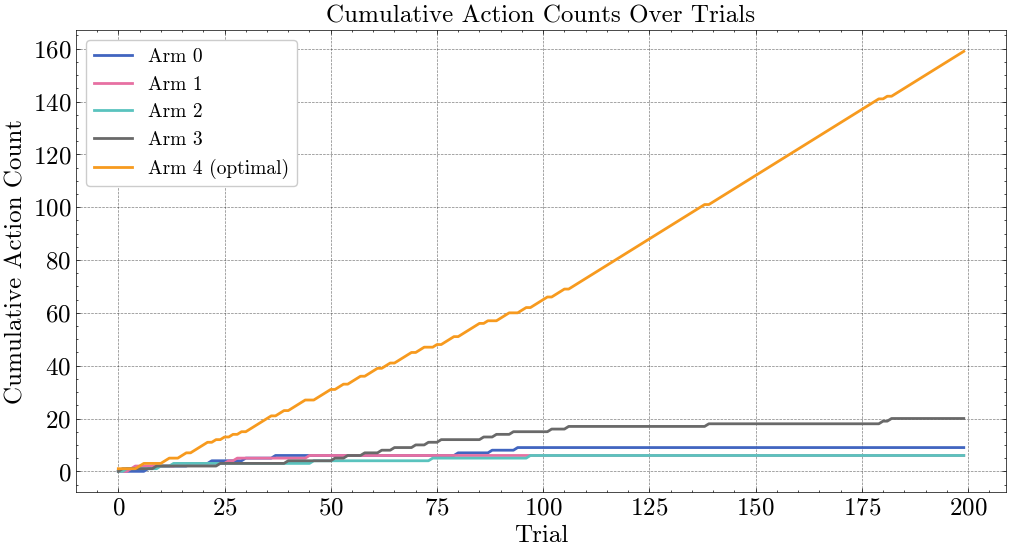

In [9]:
# Plot action counts over trials for each arm

action_counts = D_data.groupby(['trial', 'action']).size().unstack(fill_value=0)

# Sort by trial to ensure proper cumulative sum
action_counts = action_counts.sort_index()

# Cumulative sum over trials
cumulative_counts = action_counts.cumsum()

optimal_action = D_data['optimal_action'].values[0]

# Rename optimal action column


plt.figure(figsize=(12, 6))
renamed_cumulative_counts = cumulative_counts.rename(columns={optimal_action: f'{optimal_action} (optimal)'}, inplace=False)

# Plot cumulative action counts
for action in renamed_cumulative_counts.columns:
    plt.plot(renamed_cumulative_counts.index, renamed_cumulative_counts[action], label=f'Arm {action}' if action != optimal_action else f'Action {action} (optimal)', linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Cumulative Action Count')
plt.title(f'Cumulative Action Counts Over Trials')
plt.legend()
plt.show()

##### Q(a) over Trials

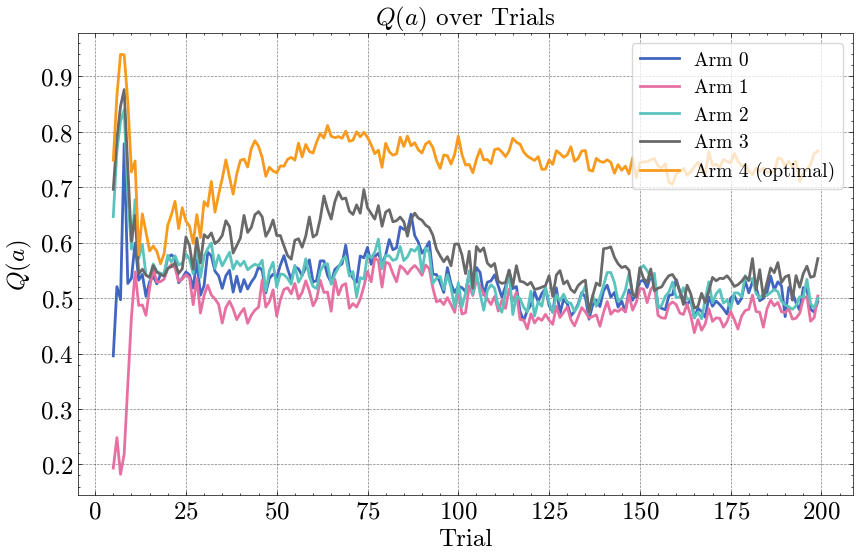

In [10]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(D_data['trial'], D_data[f'Q_value_{i}'], label=f'Arm {i}' if i != optimal_action else f'Arm {i} (optimal)', linewidth=2)


plt.xlabel('Trial')
plt.ylabel(r'$Q(a)$')
plt.title(rf'$Q(a)$ over Trials')
plt.legend(framealpha=0.75, loc='upper right', fontsize=14)
plt.show()

##### Cumulative Mean Reward per Action over Trials

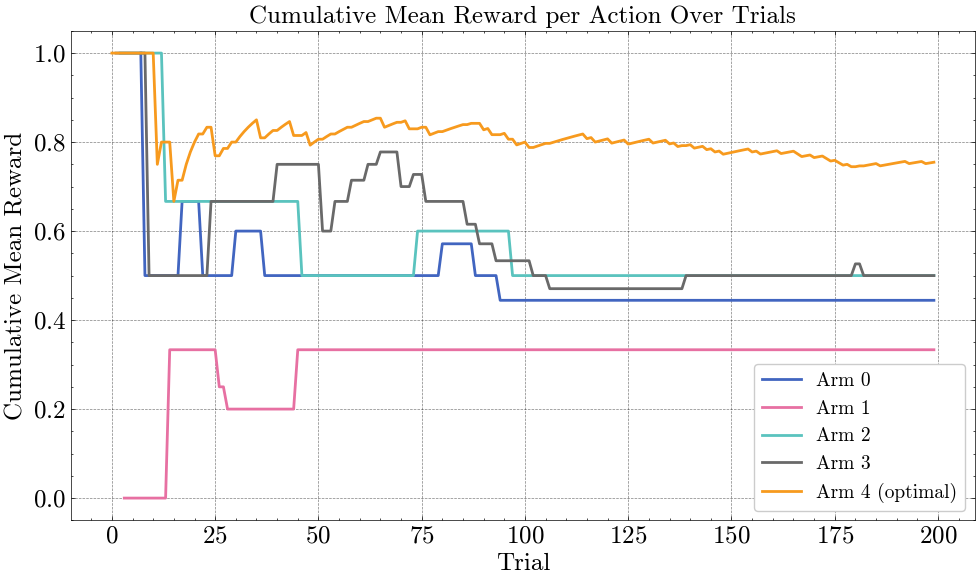

In [11]:
# plot mean cumulative reward per action
# Get list of all actions and trials
actions = D_data['action'].unique()
trials = D_data['trial'].unique()

# Initialize an empty list to collect results
records = []

# Initialize dicts to track cumulative reward and count for each action
cum_reward = {a: 0 for a in actions}
cum_count = {a: 0 for a in actions}

    
# Update cumulative sums for actions seen in this trial
for _, row in D_data.iterrows():
    t = row['trial']
    a = row['action']
    r = row['label']
    cum_reward[a] += r
    cum_count[a] += 1

    # For each action, compute cumulative mean so far
    for a in actions:
        if cum_count[a] > 0:
            mean = cum_reward[a] / cum_count[a]
        else:
            mean = np.nan
        records.append({'trial': t, 'action': a, 'cum_mean': mean})

# Create final DataFrame
df_cum_mean = pd.DataFrame(records)

plt.figure(figsize=(10, 6))

for i, group in df_cum_mean.groupby('action'):
    plt.plot(group['trial'], group['cum_mean'], label=f'Arm {i}' if i != optimal_action else f'Arm {i} (optimal)', linewidth=2)

plt.xlabel('Trial')
plt.ylabel('Cumulative Mean Reward')
plt.title('Cumulative Mean Reward per Action Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

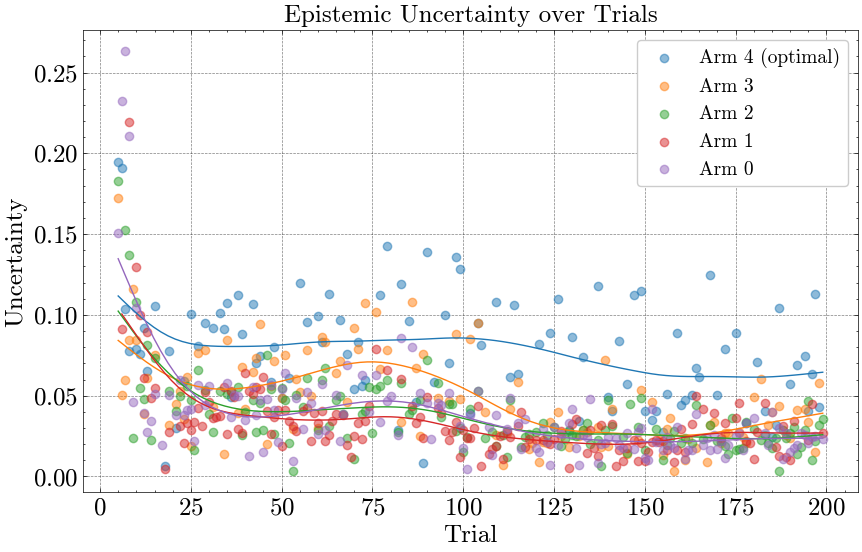

In [12]:
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')
colors = {action: cmap(i) for i, action in enumerate(actions)}


for action in actions:
    valid_indices = D_data[f'U_value_{action}'].notnull() & (D_data[f'U_value_{action}'] != 0) & (D_data[f'U_value_{action}'] < 100) 

    plt.scatter(D_data['trial'][valid_indices], D_data[f'U_value_{action}'][valid_indices], label=f"Arm {action}" if action != optimal_action else f"Arm {action} (optimal)", color=colors[action], alpha=0.5)    
    
    x_grid = np.linspace(D_data['trial'][valid_indices].min(), D_data[f'trial'].max(), 100)
    
    y_total_uncertainty = csaps(D_data['trial'][valid_indices], D_data[f'U_value_{action}'][valid_indices], smooth=0.0001)

    plt.plot(x_grid, y_total_uncertainty(x_grid), color = colors[action])


plt.ylabel('Uncertainty')
plt.title(f'{uncertainty_name} Uncertainty over Trials')
plt.xlabel('Trial')
plt.legend()
plt.show()

### Plotting over Multiple Runs

##### Parameters (EDIT cell below)

In [13]:
exploration_rate = 5
uncertainty_type = 'ev'
uncertainty_name = 'Epistemic'
p = 0.7
model = 'qwen7b'

# results_directory = f"results/bandits/buttons/{model}/experiment_1/exploration_{uncertainty_type}_{exploration_rate}/"
results_directory = f"results/bandits/buttons/exploration_mid_{p}_{uncertainty_type}_{exploration_rate}/"

seeds = list(range(10))

In [14]:
D_data_list = [None] * len(seeds)

for seed in seeds:
    run_name = f"exp_{exploration_rate}_{uncertainty_type}_seed_{seed}.csv"
    
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"D_{run_name}" in filename or f"seed_{seed}.csv" in filename:
            D_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            
            # Compute cumulative label

            D_data['cum_reward'] = D_data['label'].cumsum()
            # D_data['cum_reward'] = D_data['reward'].cumsum()
            D_data['cum_regret'] = D_data['regret'].cumsum()
            
            D_data['averaged_regret'] = 0.2 * (D_data['action'] != D_data['optimal_action']).astype(int)
            D_data['cum_averaged_regret'] = D_data['averaged_regret'].cumsum()
            
            D_data_list[seed] = D_data

##### Run Metrics

In [15]:
Trial_T = 200

print(f"exploration rate: {exploration_rate}; uncertainty type: {uncertainty_type}")

cum_reward_list = []
cum_averaged_regret_list = []

for D_data in D_data_list:
    cum_reward_list.append(D_data.loc[D_data['trial'] == Trial_T-1, 'cum_reward'].values[0])
    cum_averaged_regret_list.append(D_data.loc[D_data['trial'] == Trial_T-1, 'cum_averaged_regret'].values[0])
    
median_reward = np.median(cum_reward_list)/Trial_T

mean_reward = np.mean(cum_reward_list)/Trial_T
std_reward = np.std(np.array(cum_reward_list)/Trial_T)


mean_regret = np.mean(cum_averaged_regret_list)/Trial_T
std_regret = np.std(np.array(cum_averaged_regret_list)/Trial_T)
median_reward = np.median(cum_averaged_regret_list)/Trial_T

# worst case regret: taking cum_averaged regrets from worst 3 seeds
worst_case_mean_regret = np.mean(sorted(cum_averaged_regret_list)[-3:])/Trial_T
worst_case_std_regret = np.std(np.array(sorted(cum_averaged_regret_list)[-3:]))/Trial_T

print(f"Mean regret at T={Trial_T}: {mean_regret: .3f} +/-{std_regret: .3f}")
# print(f"Median regret at T={Trial_T}: {median_reward: .3f}")

print(f"Mean worst case regret at T={Trial_T}: {worst_case_mean_regret: .3f} +/-{worst_case_std_regret: .3f}")

# print(f"Mean reward at T={Trial_T}: {mean_reward: .3f}")
# print(f"Std reward at T={Trial_T}: {std_reward: .3f}")
print(f"Median reward at T={Trial_T}: {np.median(cum_reward_list)/Trial_T: .3f}")


exploration rate: 5; uncertainty type: ev
Mean regret at T=200:  0.092 +/- 0.037
Mean worst case regret at T=200:  0.135 +/- 0.007
Median reward at T=200:  0.682


In [16]:
suffix_failure_count = 0

suffix_start = 100
suffix_end = 200

for D_data in D_data_list:
    optimal_action = D_data['optimal_action'].values[0]
    
    # is optimal action taken in between suffix_start and suffix_end
    
    action_taken = D_data.loc[(D_data['trial'] >= suffix_start) & (D_data['trial'] <= suffix_end), 'action'].values
    
    if optimal_action not in action_taken:
        suffix_failure_count += 1

suffix_fail_freq = suffix_failure_count / len(D_data_list)    

print("Suffix failure frequency (T/2): ", suffix_fail_freq)

Suffix failure frequency (T/2):  0.0


In [17]:
T = 200

K_min_action_freq_list = []

for D_data in D_data_list:
    # count the frequency of the action taken in the first T trials
    action_taken = D_data.loc[D_data['trial'] <= T, 'action'].values
    action_counts = {}
    for action in action_taken:
        if action not in action_counts:
            action_counts[action] = 0
        action_counts[action] += 1
    min_action_count = min(action_counts.values())
    num_actions = len(action_counts)
    min_action_freq = min_action_count / T
    K_min_action_freq = num_actions * min_action_freq
    K_min_action_freq_list.append(K_min_action_freq)
    
mean_K_min_action_freq = np.mean(K_min_action_freq_list)
print("Mean K_min_action_freq: ", mean_K_min_action_freq)

Mean K_min_action_freq:  0.2425


##### Cumulative Mean Regret over Trials

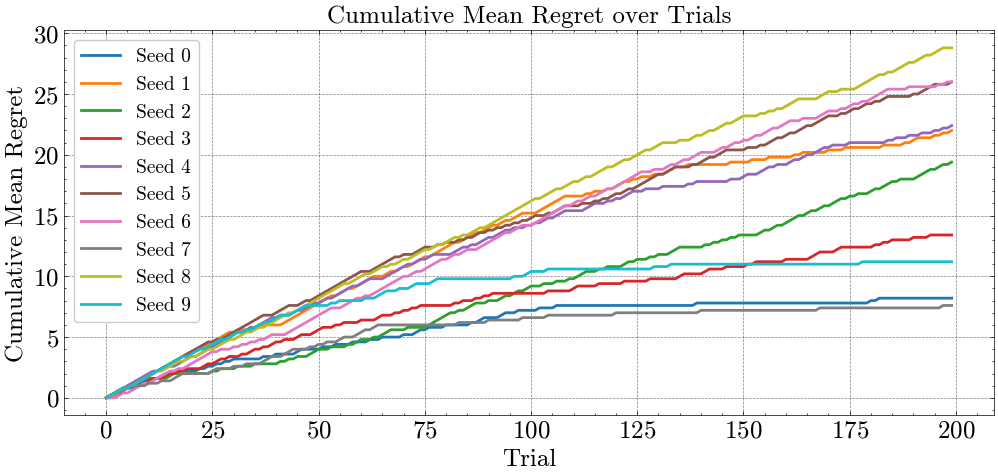

In [18]:
plt.figure(figsize=(12, 5))

cmap = plt.get_cmap('tab10')
colors = {seed: cmap(seed) for seed in seeds}

for seed in seeds:
    plt.plot(D_data_list[seed]['trial'], D_data_list[seed]['cum_averaged_regret'], label=f'Seed {seed}', color=colors[seed], linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Cumulative Mean Regret')
plt.title(f'Cumulative Mean Regret over Trials')
plt.legend()



##### Cumulative Reward over Trials

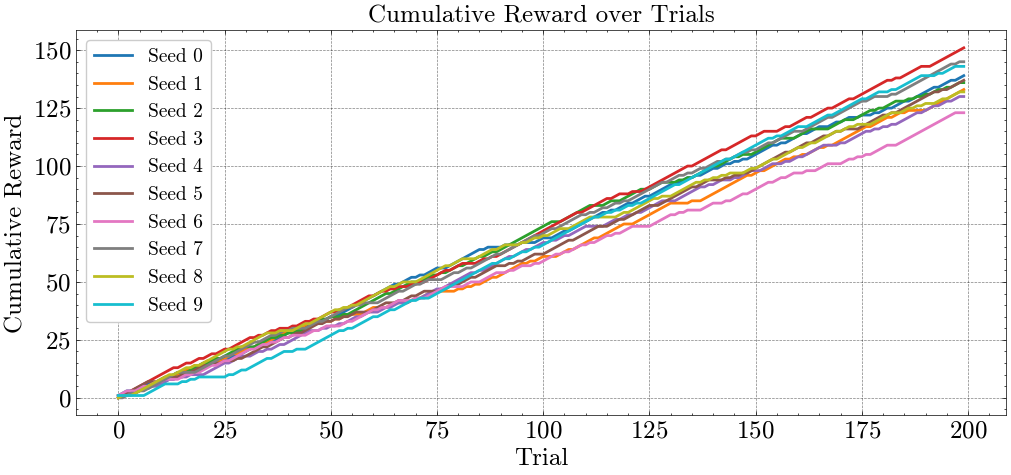

In [19]:
# plot cumulative reward against trials for each seed

cmap = plt.get_cmap('tab10')
colors = {seed: cmap(seed) for seed in seeds}

plt.figure(figsize=(12, 5))
for seed in seeds:
    plt.plot(D_data_list[seed]['trial'], D_data_list[seed]['cum_reward'], color=colors[seed], label=f'Seed {seed}', linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Trials')
plt.legend()


##### Cumulative Regret over Trials

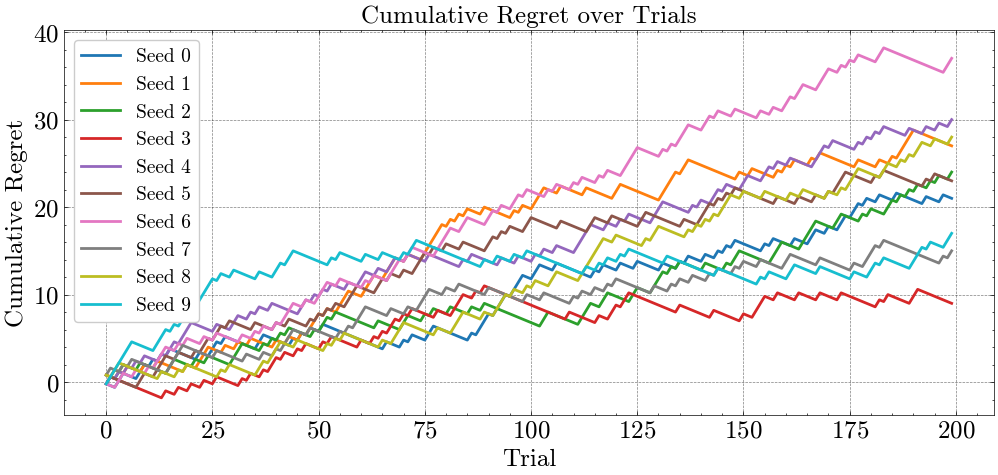

In [20]:
# plot cumulative regret against trials for each seed
plt.figure(figsize=(12, 5))
for seed in seeds:
    plt.plot(D_data_list[seed]['trial'], D_data_list[seed]['cum_regret'], label=f'Seed {seed}', color=colors[seed], linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Trials')
plt.legend()
